# TensorFlow를 이용해 ConvNet 각 단계 시각화하기

In [2]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# 한글출력
# matplotlib.rc('font', family='AppleGothic')  # MacOS
# matplotlib.rc('font', family='Malgun Gothic')  # Windows
matplotlib.rc('font', family='NanumBarunGothic')  # Linux
plt.rcParams['axes.unicode_minus'] = False

In [3]:
import sys
import numpy as np
import tensorflow as tf

# mini-batch function
def shuffle_batch(features, labels, batch_size):
    rnd_idx = np.random.permutation(len(features))
    n_batches = len(features) // batch_size
    for batch_idx in np.array_split(rnd_idx, n_batches):
        batch_images, batch_labels = features[batch_idx], labels[batch_idx]
        yield batch_images, batch_labels

## 1. Data Load

In [4]:
from keras.datasets import mnist

(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

train_images = train_images.reshape([-1, 28, 28, 1])
train_images = train_images.astype('float32') / 255

test_images = test_images.reshape([-1, 28, 28, 1])
test_images = test_images.astype('float32') / 255

print('train_images.shape :', train_images.shape)
print('train_labels.shape :', train_labels.shape)
print('test_images.shape :', test_images.shape)
print('test_labels.shape :', test_labels.shape)

train_images.shape : (60000, 28, 28, 1)
train_labels.shape : (60000,)
test_images.shape : (10000, 28, 28, 1)
test_labels.shape : (10000,)


## 2. ConvNet

```python
from keras import models
from keras import layers
from keras import backend as K

K.clear_session()

model = models.Sequential(
    [layers.Conv2D(32, [3, 3], padding='same', 
                  activation='relu', input_shape=(28, 28, 1)),
     layers.MaxPooling2D([2, 2]),
     layers.Conv2D(64, [3, 3], padding='same', activation='relu'), 
     layers.MaxPooling2D([2, 2]),
     layers.Conv2D(64, [3, 3], padding='same', activation='relu'), 
     layers.Flatten(),
     layers.Dense(64, activation='relu'),
     layers.Dense(10, activation='softmax')]
)

model.summary()

'''
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
=================================================================
conv2d_1 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 7, 64)          36928     
_________________________________________________________________
flatten_1 (Flatten)          (None, 3136)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                200768    
_________________________________________________________________
dense_2 (Dense)              (None, 10)                650       
=================================================================
Total params: 257,162
Trainable params: 257,162
Non-trainable params: 0
_________________________________________________________________
'''
```

In [5]:
# reset graph
tf.reset_default_graph()

# placeholder
inputs = tf.placeholder(tf.float32, shape=[None, 28, 28, 1])  # [samples, height, width, channels]
labels = tf.placeholder(tf.int32, shape=(None, ))

# Conv Net
conv1 = tf.layers.conv2d(inputs=inputs, filters=32, kernel_size=[3, 3], 
                         padding='same', activation=tf.nn.relu)
max_pooling2d_1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[2, 2], strides=2)
conv2 = tf.layers.conv2d(max_pooling2d_1, 64, [3, 3], padding='same', activation=tf.nn.relu)
max_pooling2d_2 = tf.layers.max_pooling2d(conv2, [2, 2], 2)
conv3 = tf.layers.conv2d(max_pooling2d_2, 64, [3, 3], padding='same', activation=tf.nn.relu)

# Dense
conv3_flat = tf.layers.flatten(conv3)
dense1 = tf.layers.dense(conv3_flat, 64, activation=tf.nn.relu)
logits = tf.layers.dense(dense1, 10, activation=None)

# loss
cross_entropy = tf.losses.sparse_softmax_cross_entropy(labels=labels, logits=logits)
loss = tf.reduce_mean(cross_entropy)
# optimizer
train_op = tf.train.RMSPropOptimizer(0.001).minimize(loss)

# metrics
correct = tf.nn.in_top_k(predictions=logits, targets=labels, k=1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

## 3. Training

In [6]:
# Train
n_epochs = 5
batch_size = 64

sess = tf.Session()
sess.run(tf.global_variables_initializer())
n_batches = len(train_images) // batch_size
for epoch in range(n_epochs):
    for iteration in range(n_batches):
        print("\r{}%".format(100 * iteration // n_batches), end="")
        sys.stdout.flush()
        batch_images, batch_labels = next(shuffle_batch(train_images, train_labels, batch_size))
        sess.run(train_op, feed_dict={inputs: batch_images,
                                      labels: batch_labels})
    train_loss, train_acc = sess.run([loss, accuracy],
                                     feed_dict={inputs: batch_images, labels: batch_labels})
    print('\repoch: {} - train_loss: {:.4f} - train_acc: {:.4f}'.format(epoch+1,
                                                                        train_loss,
                                                                        train_acc))
# eval
test_loss, test_acc = sess.run([loss, accuracy],
                               feed_dict={inputs: test_images, labels: test_labels})
print('test_loss: {:.4f} - test_acc: {:.4f}'.format(test_loss, test_acc))

epoch: 1 - train_loss: 0.0122 - train_acc: 1.0000
epoch: 2 - train_loss: 0.0009 - train_acc: 1.0000
epoch: 3 - train_loss: 0.0002 - train_acc: 1.0000
epoch: 4 - train_loss: 0.0005 - train_acc: 1.0000
epoch: 5 - train_loss: 0.0003 - train_acc: 1.0000
test_loss: 0.0428 - test_acc: 0.9889


## 4. Visualization

In [7]:
out_conv1, out_maxpool1, out_conv2, out_maxpool2, out_conv3 = sess.run([conv1, max_pooling2d_1, conv2, max_pooling2d_2, conv3], 
                                                                       feed_dict={inputs: test_images[0].reshape([1, 28, 28, 1])})

In [14]:
print('original image shape :', test_images[0].reshape([1, 28, 28, 1]).shape)
print('\t\t | ')
print('\t\t | # conv1')
print('\t\t ↓')
print('conv1 shape :', out_conv1.shape)
print('\t\t | ')
print('\t\t | # max-pooling')
print('\t\t ↓')
print('maxpooling2d_1 shape :', out_maxpool1.shape)
print('\t\t | ')
print('\t\t | # conv2')
print('\t\t ↓')
print('conv2 shape :', out_conv2.shape)
print('\t\t | ')
print('\t\t | # max-pooling')
print('\t\t ↓')
print('maxpooling2d_2 shape :', out_maxpool2.shape)
print('\t\t | ')
print('\t\t | # conv3')
print('\t\t ↓')
print('conv3 shape :', out_conv3.shape)

original image shape : (1, 28, 28, 1)
		 | 
		 | # conv1
		 ↓
conv1 shape : (1, 28, 28, 32)
		 | 
		 | # max-pooling
		 ↓
maxpooling2d_1 shape : (1, 14, 14, 32)
		 | 
		 | # conv2
		 ↓
conv2 shape : (1, 14, 14, 64)
		 | 
		 | # max-pooling
		 ↓
maxpooling2d_2 shape : (1, 7, 7, 64)
		 | 
		 | # conv3
		 ↓
conv3 shape : (1, 7, 7, 64)


### 1) Original Data

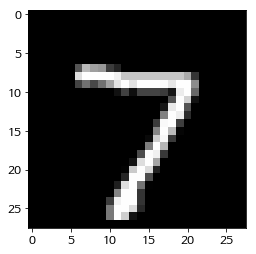

In [16]:
origin_image = test_images[0].reshape([28, 28])
plt.imshow(origin_image, cmap='gray');

## 2-1) Conv1 Result

In [38]:
viz_conv1 = out_conv1.reshape([28, 28, -1])
viz_conv1 = viz_conv1[:, :, :5]   # filters 32개 중 앞의 5개

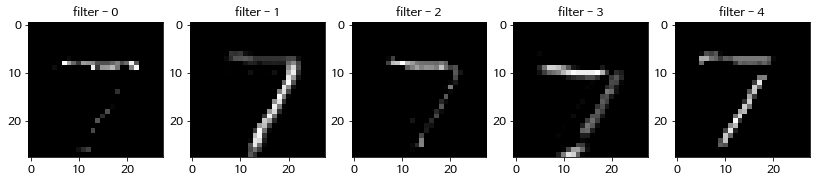

In [40]:
# matplotlib으로 plotting하기
fig, axs = plt.subplots(1, 5, figsize=(14, 5))
pl_images = [
    viz_conv1[:, :, 0],  # filter 0
    viz_conv1[:, :, 1],  # filter 1
    viz_conv1[:, :, 2],
    viz_conv1[:, :, 3],
    viz_conv1[:, :, 4]
]

titles = ['filter - 0', 'filter - 1', 'filter - 2', 'filter - 3', 'filter - 4']

for i, (image, title) in enumerate(zip(pl_images, titles)):
    axs[i].imshow(image, cmap='gray')
    axs[i].set_title(title)

### 2-2) Max-Pooling_1 Result

In [41]:
viz_maxpool1 = out_maxpool1.reshape([14, 14, 32])
viz_maxpool1 = viz_maxpool1[:, :, :5]

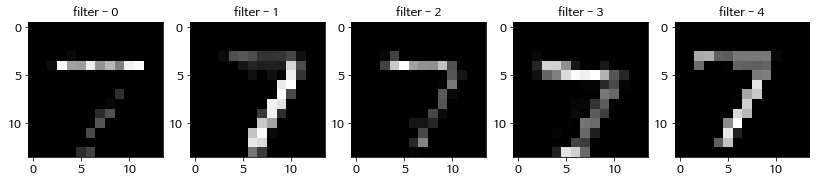

In [44]:
# matplotlib으로 plotting하기
fig, axs = plt.subplots(1, 5, figsize=(14, 5))
pl_images = [
    viz_maxpool1[:, :, 0],  # filter 0
    viz_maxpool1[:, :, 1],  # filter 1
    viz_maxpool1[:, :, 2],
    viz_maxpool1[:, :, 3],
    viz_maxpool1[:, :, 4]
]

titles = ['filter - 0', 'filter - 1', 'filter - 2', 'filter - 3', 'filter - 4']

for i, (image, title) in enumerate(zip(pl_images, titles)):
    axs[i].imshow(image, cmap='gray')
    axs[i].set_title(title)

### 3-1) Conv2 Result

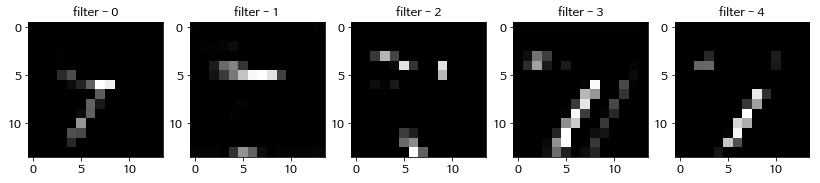

In [46]:
viz_conv2 = out_conv2.reshape([14, 14, -1])
viz_conv2 = viz_conv2[:, :, :5]   # filters 32개 중 앞의 5개

# matplotlib으로 plotting하기
fig, axs = plt.subplots(1, 5, figsize=(14, 5))
pl_images = [
    viz_conv2[:, :, 0],  # filter 0
    viz_conv2[:, :, 1],  # filter 1
    viz_conv2[:, :, 2],
    viz_conv2[:, :, 3],
    viz_conv2[:, :, 4]
]

titles = ['filter - 0', 'filter - 1', 'filter - 2', 'filter - 3', 'filter - 4']

for i, (image, title) in enumerate(zip(pl_images, titles)):
    axs[i].imshow(image, cmap='gray')
    axs[i].set_title(title)

### 3-2) Max-Pooling2 Result

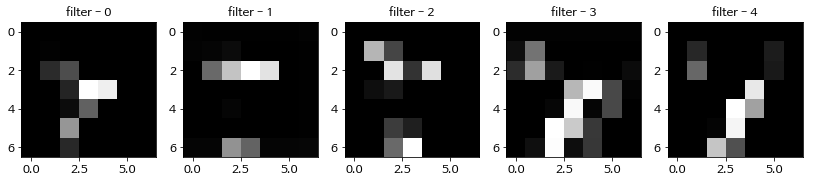

In [49]:
viz_maxpool2 = out_maxpool2.reshape([7, 7, 64])
viz_maxpool2 = viz_maxpool2[:, :, :5]

# matplotlib으로 plotting하기
fig, axs = plt.subplots(1, 5, figsize=(14, 5))
pl_images = [
    viz_maxpool2[:, :, 0],  # filter 0
    viz_maxpool2[:, :, 1],  # filter 1
    viz_maxpool2[:, :, 2],
    viz_maxpool2[:, :, 3],
    viz_maxpool2[:, :, 4]
]

titles = ['filter - 0', 'filter - 1', 'filter - 2', 'filter - 3', 'filter - 4']

for i, (image, title) in enumerate(zip(pl_images, titles)):
    axs[i].imshow(image, cmap='gray')
    axs[i].set_title(title)

### 4) Conv3 Result

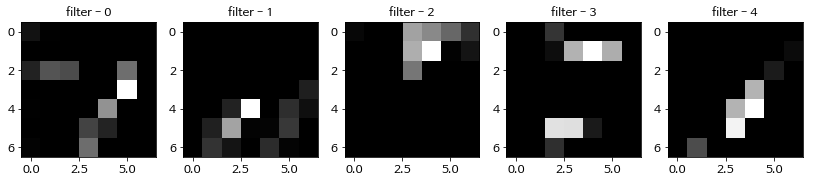

In [50]:
viz_conv3 = out_conv3.reshape([7, 7, -1])
viz_conv3 = viz_conv3[:, :, :5]   # filters 32개 중 앞의 5개

# matplotlib으로 plotting하기
fig, axs = plt.subplots(1, 5, figsize=(14, 5))
pl_images = [
    viz_conv3[:, :, 0],  # filter 0
    viz_conv3[:, :, 1],  # filter 1
    viz_conv3[:, :, 2],
    viz_conv3[:, :, 3],
    viz_conv3[:, :, 4]
]

titles = ['filter - 0', 'filter - 1', 'filter - 2', 'filter - 3', 'filter - 4']

for i, (image, title) in enumerate(zip(pl_images, titles)):
    axs[i].imshow(image, cmap='gray')
    axs[i].set_title(title)